# **🏠 부동산 실거래가 Baseline code**
> 부동산 실거래가 예측 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 RandomForest를 활용해 ML 방법론들을 실제 대회에 적용해보도록 하겠습니다.
> 강의는 google colab으로 실행하였기에 아래의 베이스라인 코드와는 일부 차이가 있을 수 있습니다.

## Contents
- Library Import
- Data Load
- Data Preprocessing
- Feature Engineering
- Model Training
- Inference
- Output File Save


## 1.Library Import
- 필요한 라이브러리를 불러옵니다.

In [ ]:
# !pip install eli5==0.13.0

#한글 폰트 사용을 위한 라이브러리입니다.
# !apt-get install -y fonts-nanum

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [ ]:
!pip install wandb

In [ ]:
import os
import gc
import re
import pickle
import joblib

from collections import Counter

# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns
import wandb # WandB 사용을 위한 라이브러리

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, f1_score
from lightgbm import LGBMClassifier, LGBMRegressor
import lightgbm as lgb
from sklearn import metrics


# import eli5
# from eli5.sklearn import PermutationImportance

## 2.Data Load

#### 2.1. 데이터 로드

In [ ]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = '/data/ephemeral/home/train.csv'
test_path  = '/data/ephemeral/home/test.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

In [ ]:
# Train data와 Test data shape은 아래와 같습니다.
print('Train data shape : ', dt.shape, 'Test data shape : ', dt_test.shape)

Train data shape :  (1118822, 52) Test data shape :  (9272, 51)


In [ ]:
# Train과 Test data를 살펴보겠습니다.
display(dt.head(1))
display(dt_test.head(1))      # 부동산 실거래가(=Target) column이 제외된 모습입니다.

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000


,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,202307,26,5,1987,...,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0


## 3.Data Preprocessing

### 3.0. train/test 합치기

- 모델링 전에 데이터 내 결측치, 이상치 등을 제거하고 범주형과 연속형 변수를 살펴보도록 하겠습니다!
- 먼저, 용이한 전처리를 위해 train과 test data를 합친 하나의 데이터로 진행하도록 하겠습니다.

In [ ]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt['is_test'] = 0
dt_test['is_test'] = 1
concat = pd.concat([dt, dt_test])     # 하나의 데이터로 만들어줍니다.

In [ ]:
dt.shape, dt_test.shape, concat.shape

((1118822, 53), (9272, 52), (1128094, 53))

In [ ]:
concat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1128094 entries, 0 to 9271
Data columns (total 53 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1128094 non-null  object 
 1   번지                      1127867 non-null  object 
 2   본번                      1128019 non-null  float64
 3   부번                      1128019 non-null  float64
 4   아파트명                    1125958 non-null  object 
 5   전용면적(㎡)                 1128094 non-null  float64
 6   계약년월                    1128094 non-null  int64  
 7   계약일                     1128094 non-null  int64  
 8   층                       1128094 non-null  int64  
 9   건축년도                    1128094 non-null  int64  
 10  도로명                     1128094 non-null  object 
 11  해제사유발생일                 6195 non-null     float64
 12  등기신청일자                  1128094 non-null  object 
 13  거래유형                    1128094 non-null  object 
 14  중개사소재지    

In [ ]:
concat['is_test'].value_counts()      # train과 test data가 하나로 합쳐진 것을 확인할 수 있습니다.

is_test
0    1118822
1       9272
Name: count, dtype: int64

In [ ]:
# 칼럼 이름을 쉽게 바꿔주겠습니다. 다른 칼럼도 사용에 따라 바꿔주셔도 됩니다!
concat = concat.rename(columns={'전용면적(㎡)':'전용면적'})

#### 날짜데이터[계약년월/일] 전처리

In [ ]:
concat = pd.DataFrame(concat)

# 계약년월을 문자열로 변환하고, 연도와 월로 분리
concat['계약년월'] = concat['계약년월'].astype(str)
concat['계약년'] = concat['계약년월'].str[:4]
concat['계약월'] = concat['계약년월'].str[4:]

# 계약일을 문자열로 변환
concat['계약일'] = concat['계약일'].astype(str)

# date 문자열 생성
concat['date'] = concat['계약년'] + '-' + concat['계약월'] + '-' + concat['계약일']

# date 문자열을 datetime 형식으로 변환
concat['date'] = pd.to_datetime(concat['date'], format='%Y-%m-%d')

# 불필요한 중간 컬럼 삭제 (선택 사항)
# concat.drop(columns=['계약년', '계약월'], inplace=True)

# 결과 확인
print(concat.head())

             시군구     번지     본번   부번    아파트명   전용면적    계약년월 계약일  층  건축년도  ...  \
0  서울특별시 강남구 개포동  658-1  658.0  1.0  개포6차우성  79.97  201712   8  3  1987  ...   
1  서울특별시 강남구 개포동  658-1  658.0  1.0  개포6차우성  79.97  201712  22  4  1987  ...   
2  서울특별시 강남구 개포동  658-1  658.0  1.0  개포6차우성  54.98  201712  28  5  1987  ...   
3  서울특별시 강남구 개포동  658-1  658.0  1.0  개포6차우성  79.97  201801   3  4  1987  ...   
4  서울특별시 강남구 개포동  658-1  658.0  1.0  개포6차우성  79.97  201801   8  2  1987  ...   

  사용허가여부  관리비 업로드        좌표X        좌표Y                  단지신청일    target  \
0      Y        N  127.05721  37.476763  2022-11-17 10:19:06.0  124000.0   
1      Y        N  127.05721  37.476763  2022-11-17 10:19:06.0  123500.0   
2      Y        N  127.05721  37.476763  2022-11-17 10:19:06.0   91500.0   
3      Y        N  127.05721  37.476763  2022-11-17 10:19:06.0  130000.0   
4      Y        N  127.05721  37.476763  2022-11-17 10:19:06.0  117000.0   

  is_test   계약년  계약월       date  
0       0  2017   12 2017-12

### 3.1. 결측치 탐색 및 보간
- 결측치를 처리할 때 많이 쓰는 방법은 삭제(Deletion)과 대체(Imputation) 입니다.
- 본 Baseline에서는 결측치가 90% 이상을 차지하는 변수의 결측치는 제거하고, 나머지 결측치는 대체하도록 하겠습니다.
  - 연속형 변수의 경우에는 선형보간(Linear interpolation)으로 대체하겠습니다.
  - 범주형 변수의 경우에는 'NULL' 이라는 임의의 범주로 대체해주도록 하겠습니다.

- 참고 ✅
  - 선형보간(Linear interpolation)이란 두 점의 값이 주어졌을 때 **그 사이의 값**을 추정하기 위해 직선 거리에 따라 선형적으로 계산하는 방법입니다.
  - 아래 두개의 붉은 점 사이에 ($x$, $y$) 값을 추정하기 위해, 해당 점이 두 붉은 점을 이은 선형적인 선분에 있다고 가정하고, 단순 비례식으로 ($x$, $y$)를 추정해 보간하는 방법입니다.
  - [참고자료](https://ko.wikipedia.org/wiki/%EC%84%A0%ED%98%95_%EB%B3%B4%EA%B0%84%EB%B2%95#:~:text=%EC%84%A0%ED%98%95%20%EB%B3%B4%EA%B0%84%EB%B2%95(%E7%B7%9A%E5%9E%8B%E8%A3%9C%E9%96%93%E6%B3%95,%EC%9C%BC%EB%A1%9C%20%EA%B3%84%EC%82%B0%ED%95%98%EB%8A%94%20%EB%B0%A9%EB%B2%95%EC%9D%B4%EB%8B%A4.)


In [ ]:
# 실제로 결측치라고 표시는 안되어있지만 아무 의미도 갖지 않는 element들이 아래와 같이 존재합니다.
# 아래 3가지의 경우 모두 아무 의미도 갖지 않는 element가 포함되어 있습니다.
display(concat['등기신청일자'].value_counts())

등기신청일자
            1111271
20230630        585
20230831        496
20230428        394
20230731        374
             ...   
20230110          3
20230125          3
20230109          1
20230102          1
20230104          1
Name: count, Length: 182, dtype: int64

In [ ]:
display(concat['거래유형'].value_counts())

거래유형
-       1086451
중개거래      38123
직거래        3520
Name: count, dtype: int64

In [ ]:
display(concat['중개사소재지'].value_counts())

중개사소재지
-                          1090013
서울 노원구                        2627
서울 송파구                        2540
서울 강남구                        2508
서울 강동구                        2038
                            ...   
경기 광주시, 서울 송파구                   1
경기 안양동안구, 서울 성북구                 1
서울 노원구, 서울 동대문구, 서울 성북구          1
서울 송파구, 충남 아산시                   1
서울 강남구, 서울 노원구, 서울 송파구           1
Name: count, Length: 739, dtype: int64

In [ ]:
# 위 처럼 아무 의미도 갖지 않는 칼럼은 결측치와 같은 역할을 하므로, np.nan으로 채워 결측치로 인식되도록 합니다.
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)

In [ ]:
concat.isnull()

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,...,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test,계약년,계약월,date
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
9268,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
9269,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
9270,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


In [ ]:
# EDA에 앞서 결측치를 확인해보겠습니다.
concat.isnull().sum()

시군구                             0
번지                            227
본번                             75
부번                             75
아파트명                         2136
전용면적                            0
계약년월                            0
계약일                             0
층                               0
건축년도                            0
도로명                             0
해제사유발생일                   1121899
등기신청일자                    1111271
거래유형                      1086451
중개사소재지                    1090013
k-단지분류(아파트,주상복합등등)         877273
k-전화번호                     876850
k-팩스번호                     879348
단지소개기존clob                1058958
k-세대타입(분양형태)               876125
k-관리방식                     876125
k-복도유형                     876454
k-난방방식                     876125
k-전체동수                     877207
k-전체세대수                    876125
k-건설사(시공사)                 877637
k-시행사                      877834
k-사용검사일-사용승인일              876259
k-연면적                      876125
k-주거전용면적      

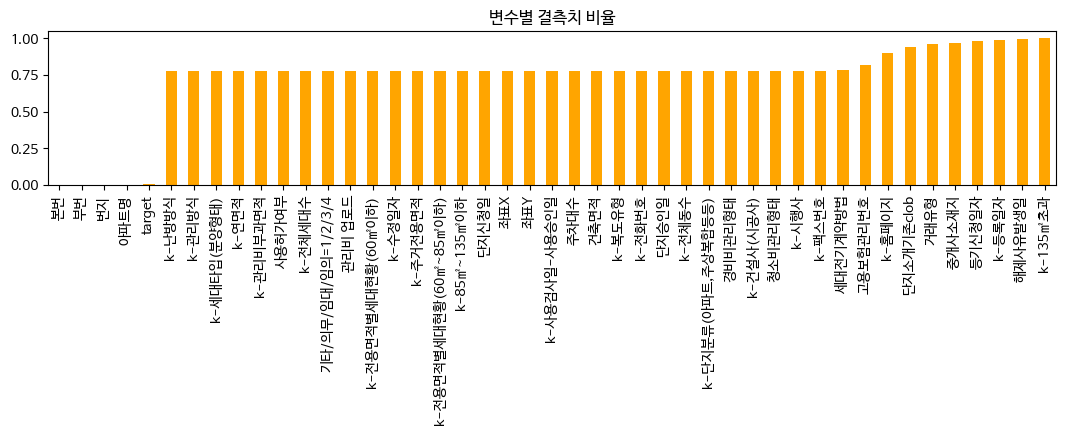

In [ ]:
# 변수별 결측치의 비율을 plot으로 그려보면 아래와 같습니다.
fig = plt.figure(figsize=(13, 2))
missing = concat.isnull().sum() / concat.shape[0]
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()

In [ ]:
print(concat.shape[0] * 0.9)

1015284.6


- 위 그래프에서 볼 수 있다시피 결측치가 100만개 이상인 칼럼들은 결측치가 해당 칼럼의 element 중 90% 이상을 차지하는 상황이 됩니다.
- 따라서 본 Baseline 에서는 이 칼럼은 예측에 도움이 되지 않는다고 판단해 삭제해주도록 하겠습니다.

In [ ]:
# Null값이 100만개 이상인 칼럼은 삭제해보도록 하겠습니다.
print('* 결측치가 100만개 이하인 변수들 :', list(concat.columns[concat.isnull().sum() <= 1000000]))     # 남겨질 변수들은 아래와 같습니다.
print('* 결측치가 100만개 이상인 변수들 :', list(concat.columns[concat.isnull().sum() >= 1000000]))

* 결측치가 100만개 이하인 변수들 : ['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target', 'is_test', '계약년', '계약월', 'date']
* 결측치가 100만개 이상인 변수들 : ['해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', '단지소개기존clob', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자']


In [ ]:
# 위에서 결측치가 100만개 이하인 변수들만 골라 새로운 concat_select 객체로 저장해줍니다.
selected = list(concat.columns[concat.isnull().sum() <= 1000000])
concat_select = concat[selected]

In [ ]:
concat.shape, concat_select.shape

((1128094, 56), (1128094, 48))

In [ ]:
concat_select.isnull().sum()     # 결측치가 100만개 초과인 칼럼이 제거된 모습은 아래와 같습니다.
# target변수는 test dataset 개수만큼(9272) 결측치가 존재함을 확인할 수 있습니다.

시군구                            0
번지                           227
본번                            75
부번                            75
아파트명                        2136
전용면적                           0
계약년월                           0
계약일                            0
층                              0
건축년도                           0
도로명                            0
k-단지분류(아파트,주상복합등등)        877273
k-전화번호                    876850
k-팩스번호                    879348
k-세대타입(분양형태)              876125
k-관리방식                    876125
k-복도유형                    876454
k-난방방식                    876125
k-전체동수                    877207
k-전체세대수                   876125
k-건설사(시공사)                877637
k-시행사                     877834
k-사용검사일-사용승인일             876259
k-연면적                     876125
k-주거전용면적                  876170
k-관리비부과면적                 876125
k-전용면적별세대현황(60㎡이하)        876170
k-전용면적별세대현황(60㎡~85㎡이하)    876170
k-85㎡~135㎡이하              876170
k-수정일자                    876170
고용보험관리번호  

In [ ]:
# 연속형 변수는 선형보간을 해주고, 범주형변수는 알수없기에 “unknown”이라고 임의로 보간해 주겠습니다.
concat_select.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1128094 entries, 0 to 9271
Data columns (total 48 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   시군구                     1128094 non-null  object        
 1   번지                      1127867 non-null  object        
 2   본번                      1128019 non-null  float64       
 3   부번                      1128019 non-null  float64       
 4   아파트명                    1125958 non-null  object        
 5   전용면적                    1128094 non-null  float64       
 6   계약년월                    1128094 non-null  object        
 7   계약일                     1128094 non-null  object        
 8   층                       1128094 non-null  int64         
 9   건축년도                    1128094 non-null  int64         
 10  도로명                     1128094 non-null  object        
 11  k-단지분류(아파트,주상복합등등)      250821 non-null   object        
 12  k-전화번호                

In [ ]:
concat_select[['본번', '부번']]

,본번,부번
0,658.0,1.0
1,658.0,1.0
2,658.0,1.0
3,658.0,1.0
4,658.0,1.0
...,...,...
9267,816.0,0.0
9268,816.0,0.0
9269,816.0,0.0
9270,816.0,0.0


In [ ]:
# 본번, 부번의 경우 float로 되어있지만 범주형 변수의 의미를 가지므로 object(string) 형태로 바꾸어주고 아래 작업을 진행하겠습니다.
concat_select['본번'] = concat_select['본번'].astype('str')
concat_select['부번'] = concat_select['부번'].astype('str')

In [ ]:
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', 'is_test']
범주형 변수: ['시군구', '번지', '본번', '부번', '아파트명', '계약년월', '계약일', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일', '계약년', '계약월', 'date']


- 연속형 변수와 범주형 변수가 알맞게 나누어졌는지 확인해보고, 이제 각각 보간을 진행합니다.

In [ ]:
# 범주형 변수에 대한 보간
concat_select[categorical_columns] = concat_select[categorical_columns].fillna('NULL')

# 연속형 변수에 대한 보간 (선형 보간)
concat_select[continuous_columns] = concat_select[continuous_columns].interpolate(method='linear', axis=0)

In [ ]:
concat_select.isnull().sum()         # 결측치가 보간된 모습을 확인해봅니다.

시군구                       0
번지                        0
본번                        0
부번                        0
아파트명                      0
전용면적                      0
계약년월                      0
계약일                       0
층                         0
건축년도                      0
도로명                       0
k-단지분류(아파트,주상복합등등)        0
k-전화번호                    0
k-팩스번호                    0
k-세대타입(분양형태)              0
k-관리방식                    0
k-복도유형                    0
k-난방방식                    0
k-전체동수                    0
k-전체세대수                   0
k-건설사(시공사)                0
k-시행사                     0
k-사용검사일-사용승인일             0
k-연면적                     0
k-주거전용면적                  0
k-관리비부과면적                 0
k-전용면적별세대현황(60㎡이하)        0
k-전용면적별세대현황(60㎡~85㎡이하)    0
k-85㎡~135㎡이하              0
k-수정일자                    0
고용보험관리번호                  0
경비비관리형태                   0
세대전기계약방법                  0
청소비관리형태                   0
건축면적                      0
주차대수                

- Baseline에서는 단순 결측치들을 제거하거나 보간했지만,
EDA를 통해 변수들의 흐름을 조금 더 파악하고 더 나은 interpolation 등의 방법을 고려해볼 수 있을 것 같습니다.

### 3.2. 이상치 처리

- 이번엔 이상치를 처리해봅시다.
- 이상치를 처리하는 방법은 IQR, Z-score 등 다양한 방법이 있습니다. 가장 쉽고 직관적으로 접근하는 방법은 기본 통계치를 이용하는 것입니다.
- 본 baseline에서는 IQR를 이용한 방법을 사용하겠습니다.

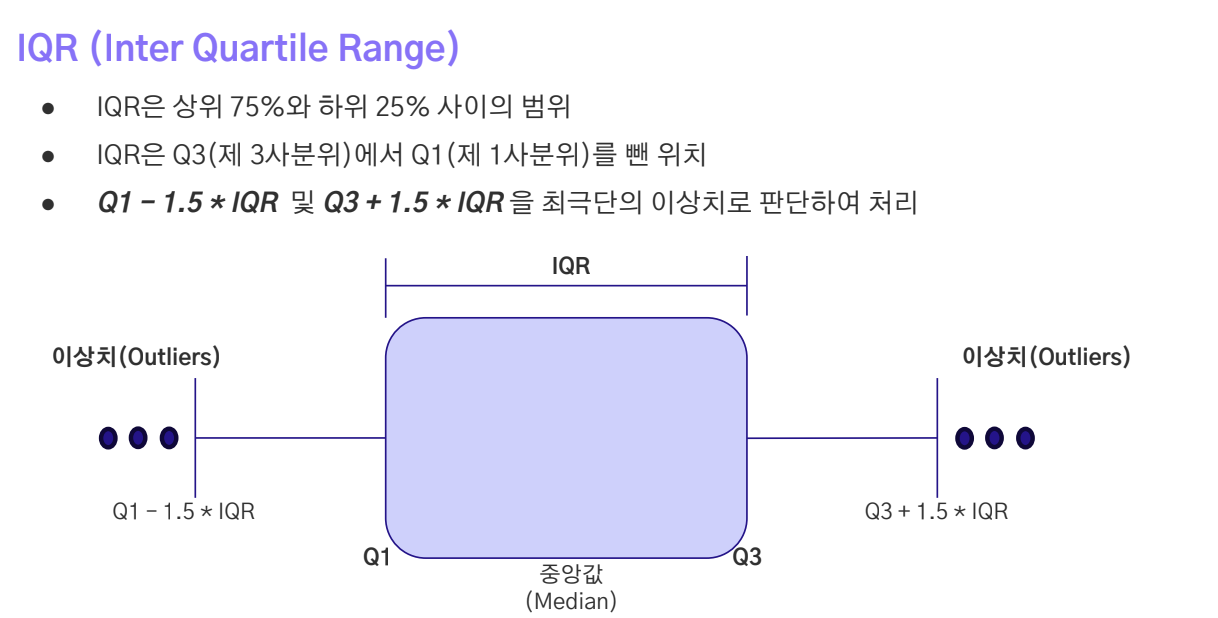

In [ ]:
# 이상치 제거 이전의 shape은 아래와 같습니다.
print(concat_select.shape)

(1128094, 48)


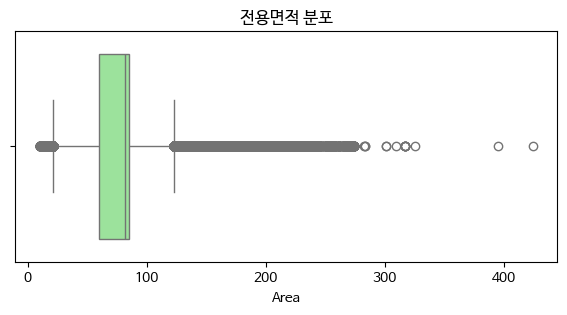

In [ ]:
# 대표적인 연속형 변수인 “전용 면적” 변수 관련한 분포를 먼저 살펴보도록 하겠습니다.
fig = plt.figure(figsize=(7, 3))
sns.boxplot(data = concat_select, x = '전용면적', color='lightgreen')
plt.title('전용면적 분포')
plt.xlabel('Area')
plt.show()

In [ ]:
# 이상치 제거 방법에는 IQR을 이용하겠습니다.
def remove_outliers_iqr(dt, column_name):
    df = dt.query('is_test == 0')       # train data 내에 있는 이상치만 제거하도록 하겠습니다.
    df_test = dt.query('is_test == 1')

    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    result = pd.concat([df, df_test])   # test data와 다시 합쳐주겠습니다.
    return result

In [ ]:
# 위 방법으로 전용 면적에 대한 이상치를 제거해보겠습니다.
concat_select = remove_outliers_iqr(concat_select, '전용면적')

In [ ]:
# 이상치 제거 후의 shape은 아래와 같습니다. 약 10만개의 데이터가 제거된 모습을 확인할 수 있습니다.
print(concat_select.shape)

(1038846, 48)


In [ ]:
concat_select['is_test'].value_counts()     # 또한, train data만 제거되었습니다.

is_test
0    1029574
1       9272
Name: count, dtype: int64

In [ ]:
print(concat_select.columns)

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도',
       '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)',
       'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)',
       'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
       'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수',
       '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y',
       '단지신청일', 'target', 'is_test', '계약년', '계약월', 'date'],
      dtype='object')


In [ ]:
concat_select = concat_select.drop(columns=['k-전화번호', 'k-팩스번호', '고용보험관리번호'])

In [ ]:
print(concat_select.columns)

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도',
       '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '경비비관리형태',
       '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일',
       '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target', 'is_test', '계약년',
       '계약월', 'date'],
      dtype='object')


In [ ]:
# 칼럼 이름을 영어로 바꿔주겠습니다.!
concat_select = concat_select.rename(columns={
                                            '시군구' : 'City District',
                                            '번지' : 'Beonji',
                                            '본번' : 'Main Number',
                                            '부번' : 'Sub Number',
                                            '아파트명' : 'Apartment Name',
                                            '전용면적' : 'Exclusive Area',
                                            '계약년월' : 'Contract Year and Month',
                                            '계약일' : 'Contract Date',
                                            '층' : 'Floor',
                                            '건축년도' : 'Year Built',
                                            '도로명' : 'Road Name',
                                            'k-단지분류(아파트,주상복합등등)' : 'Complex Classification',
                                            'k-세대타입(분양형태)' : 'Household Type',
                                            'k-관리방식' : 'Management Method',
                                            'k-복도유형' : 'Corridor Type',
                                            'k-난방방식' : 'Heating Method',
                                            'k-전체동수' : 'Total Number of Buildings',
                                            'k-전체세대수' : 'Total Number of Households',
                                            'k-건설사(시공사)' : 'Construction Company (Contractor)',
                                            'k-시행사' : 'Developer',
                                            'k-사용검사일-사용승인일' : 'Inspection Approval Date',
                                            'k-연면적' : 'Gross Floor Area',
                                            'k-주거전용면적' : 'Residential Exclusive Area',
                                            'k-관리비부과면적' : 'Management Fee Area',
                                            'k-전용면적별세대현황(60㎡이하)' : 'Under 60㎡_Household Status by Exclusive Area ',
                                            'k-전용면적별세대현황(60㎡~85㎡이하)' : '60㎡ to 85㎡_Household Status by Exclusive Area ',
                                            'k-85㎡~135㎡이하' : '85㎡ to 135㎡_Household Status by Exclusive Area ',
                                            'k-수정일자' : 'Modification Date',
                                            '경비비관리형태' : 'Security Fee Management Type',
                                            '세대전기계약방법' : 'Household Electricity Contract Method',
                                            '청소비관리형태' : 'Cleaning Fee Management Type',
                                            '건축면적' : 'Building Area',
                                            '주차대수' : 'Number of Parking Spaces',
                                            '기타/의무/임대/임의=1/2/3/4' : 'Type1234',
                                            '단지승인일' : 'Complex Approval Date',
                                            '사용허가여부' : 'Usage Permission Status',
                                            '관리비 업로드' : 'Management Fee Upload',
                                            '좌표X' : 'Coordinate X',
                                            '좌표Y' : 'Coordinate Y',
                                            '단지신청일' : 'Complex Application Date',
                                            '계약년' : 'Contract Year',
                                            '계약월' : 'Contract Month'
                                            })

In [ ]:
print(concat_select.columns)

Index(['City District', 'Beonji', 'Main Number', 'Sub Number',
       'Apartment Name', 'Exclusive Area', 'Contract Year and Month',
       'Contract Date', 'Floor', 'Year Built', 'Road Name',
       'Complex Classification', 'Household Type', 'Management Method',
       'Corridor Type', 'Heating Method', 'Total Number of Buildings',
       'Total Number of Households', 'Construction Company (Contractor)',
       'Developer', 'Inspection Approval Date', 'Gross Floor Area',
       'Residential Exclusive Area', 'Management Fee Area',
       'Under 60㎡_Household Status by Exclusive Area ',
       '60㎡ to 85㎡_Household Status by Exclusive Area ',
       '85㎡ to 135㎡_Household Status by Exclusive Area ', 'Modification Date',
       'Security Fee Management Type', 'Household Electricity Contract Method',
       'Cleaning Fee Management Type', 'Building Area',
       'Number of Parking Spaces', 'Type1234', 'Complex Approval Date',
       'Usage Permission Status', 'Management Fee Upload', 'Co

## 4.Feature Engineering
- 이제 파생변수를 만들어보도록 하겠습니다.
- 파생 변수는 도메인 지식에 기반해 제작하는 것이 중요합니다.
- 주택의 가격을 예측하는 문제이기 때문에 약간의 부동산 지식을 기반으로 파생 변수를 만들어 보도록 하겠습니다.

### 시군구, 년월 분할, date 변수생성

In [ ]:
# 시군구 등 분할할 수 있는 변수들은 세부사항 고려를 용이하게 하기 위해 모두 분할해 주겠습니다.
concat_select['Gu'] = concat_select['City District'].map(lambda x : x.split()[1])
concat_select['Dong'] = concat_select['City District'].map(lambda x : x.split()[2])
del concat_select['City District']

In [ ]:
# # 결과 확인
# print(concat_select[['계약년', '계약월', '계약일', 'date']])
print(concat_select[['Contract Year', 'Contract Month', 'Contract Date', 'date']])

     Contract Year Contract Month Contract Date       date
0             2017             12             8 2017-12-08
1             2017             12            22 2017-12-22
2             2017             12            28 2017-12-28
3             2018             01             3 2018-01-03
4             2018             01             8 2018-01-08
...            ...            ...           ...        ...
9267          2023             07            19 2023-07-19
9268          2023             07            25 2023-07-25
9269          2023             08            27 2023-08-27
9270          2023             09             2 2023-09-02
9271          2023             09             4 2023-09-04

[1038846 rows x 4 columns]


In [ ]:
# # 년월 등 분할할 수 있는 변수들은 세부사항 고려를 용이하게 하기 위해 모두 분할해 주겠습니다.
# concat_select['계약년'] = concat_select['계약년월'].astype('str').map(lambda x : x[:4])
# concat_select['계약월'] = concat_select['계약년월'].astype('str').map(lambda x : x[4:])
# # del concat_select['계약년월']

# # 계약일 컬럼을 문자열로 변환
# concat_select['계약일'] = concat_select['계약일'].astype(str)

# # 년-월-일 형식으로 결합하여 새로운 date 컬럼 생성
# concat_select['date'] = concat_select['계약년'] + '-' + concat_select['계약월'] + '-' + concat_select['계약일']

# # date 컬럼을 datetime 형식으로 변환
# concat_select['date'] = pd.to_datetime(concat_select['date'], format='%Y-%m-%d')



In [ ]:
concat_select.columns

Index(['Beonji', 'Main Number', 'Sub Number', 'Apartment Name',
       'Exclusive Area', 'Contract Year and Month', 'Contract Date', 'Floor',
       'Year Built', 'Road Name', 'Complex Classification', 'Household Type',
       'Management Method', 'Corridor Type', 'Heating Method',
       'Total Number of Buildings', 'Total Number of Households',
       'Construction Company (Contractor)', 'Developer',
       'Inspection Approval Date', 'Gross Floor Area',
       'Residential Exclusive Area', 'Management Fee Area',
       'Under 60㎡_Household Status by Exclusive Area ',
       '60㎡ to 85㎡_Household Status by Exclusive Area ',
       '85㎡ to 135㎡_Household Status by Exclusive Area ', 'Modification Date',
       'Security Fee Management Type', 'Household Electricity Contract Method',
       'Cleaning Fee Management Type', 'Building Area',
       'Number of Parking Spaces', 'Type1234', 'Complex Approval Date',
       'Usage Permission Status', 'Management Fee Upload', 'Coordinate X',
    

### 강남/강북 구분

- 서울의 집값은 강남, 강북 여부에 따라 차이가 많이 난다는 사실은 많이 알려진 사실입니다.
- 따라서 강남/강북의 여부에 따라 파생변수를 생성해주도록 하겠습니다.

In [ ]:
all = list(concat_select['Gu'].unique())
gangnam = ['강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', '강동구']
gangbuk = [x for x in all if x not in gangnam]

assert len(all) == len(gangnam) + len(gangbuk)       # 알맞게 분리되었는지 체크합니다.

In [ ]:
# 강남의 여부를 체크합니다.
is_gangnam = []
for x in concat_select['Gu'].tolist() :
  if x in gangnam :
    is_gangnam.append(1)
  else :
    is_gangnam.append(0)

# 파생변수를 하나 만릅니다.
concat_select['GangNam TF'] = is_gangnam

In [ ]:
concat_select.columns

Index(['Beonji', 'Main Number', 'Sub Number', 'Apartment Name',
       'Exclusive Area', 'Contract Year and Month', 'Contract Date', 'Floor',
       'Year Built', 'Road Name', 'Complex Classification', 'Household Type',
       'Management Method', 'Corridor Type', 'Heating Method',
       'Total Number of Buildings', 'Total Number of Households',
       'Construction Company (Contractor)', 'Developer',
       'Inspection Approval Date', 'Gross Floor Area',
       'Residential Exclusive Area', 'Management Fee Area',
       'Under 60㎡_Household Status by Exclusive Area ',
       '60㎡ to 85㎡_Household Status by Exclusive Area ',
       '85㎡ to 135㎡_Household Status by Exclusive Area ', 'Modification Date',
       'Security Fee Management Type', 'Household Electricity Contract Method',
       'Cleaning Fee Management Type', 'Building Area',
       'Number of Parking Spaces', 'Type1234', 'Complex Approval Date',
       'Usage Permission Status', 'Management Fee Upload', 'Coordinate X',
    

### 신축,구축 구분

- 또한 신축인지, 구축인지의 여부도 실거래가에 큰 영향을 줄 수 있습니다.
- 따라서 건축년도에 따라 파생변수를 제작해주도록 하겠습니다.

In [ ]:
print(concat_select['Year Built'])

0       1987
1       1987
2       1987
3       1987
4       1987
        ... 
9267    2014
9268    2014
9269    2014
9270    2014
9271    2014
Name: Year Built, Length: 1038846, dtype: int64


In [ ]:
# 건축년도 분포는 아래와 같습니다. 특히 2005년이 Q3에 해당합니다.
# 2009년 이후에 지어진 건물은 10%정도 되는 것을 확인할 수 있습니다.
concat_select['Year Built'].describe(percentiles = [0.1, 0.25, 0.5, 0.75, 0.8, 0.9])

count    1.038846e+06
mean     1.998583e+03
std      9.132471e+00
min      1.961000e+03
10%      1.987000e+03
25%      1.992000e+03
50%      2.000000e+03
75%      2.005000e+03
80%      2.006000e+03
90%      2.009000e+03
max      2.023000e+03
Name: Year Built, dtype: float64

- 총개수: 약 1,038,846개의 건축년도 데이터
- 평균: 약 1998년
- 표준편차:  약 9.13년
- 최소 건축년도: 가장 오래된 건물의 건축년도는 1961년
- 10% : 전체 데이터의 하위 10%는 1987년 또는 그 이전에 지어진 건물들
- 25% (Q1) : 첫 번째 사분위수. 하위 25%의 데이터는 1992년 또는 그 이전에 지어진 건물
- 50% (Q2) : 중앙값. 데이터의 중앙값은 2000년. 즉, 전체 데이터의 절반은 2000년 또는 그 이전에 지어진 건물
- 75% (Q3) : 세 번째 사분위수. 상위 25%의 데이터는 2005년 또는 그 이후에 지어진 건물
- 80% : 상위 20%의 데이터는 2006년 또는 그 이후에 지어진 건물
- 90% : 상위 10%의 데이터는 2009년 또는 그 이후에 지어진 건물
- max : 가장 최근에 지어진 건물의 건축년도는 2023년

In [ ]:
# 2009년 이후에 지어졌으면 비교적 신축이라고 판단하고, 신축 여부 변수를 제작해보도록 하겠습니다.
concat_select['Newly Constructed'] = concat_select['Year Built'].apply(lambda x: 1 if x >= 2018 else 0)

In [ ]:
concat_select.head(1)

,Beonji,Main Number,Sub Number,Apartment Name,Exclusive Area,Contract Year and Month,Contract Date,Floor,Year Built,Road Name,...,Complex Application Date,target,is_test,Contract Year,Contract Month,date,Gu,Dong,GangNam TF,Newly Constructed
0,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,언주로 3,...,2022-11-17 10:19:06.0,124000.0,0,2017,12,2017-12-08,강남구,개포동,1,0


In [ ]:
concat_select.shape

(1038846, 48)

```
concat_select.columns
['번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명',
       'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식',
       'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사',
       'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '고용보험관리번호',
       '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4',
       '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target',
       'is_test', '계약년', '계약월', 'date', '구', '동', '강남여부']
```

In [ ]:
# important_columns = ['전용면적', '계약년월', '강남여부', '구',  'target']

- 위 두 사항 외에도 외부 공공 데이터를 이용하거나, EDA를 통해 더 많은 변수를 제작할 수 있습니다.

## 5.Model Training

- 이제 위에서 만든 파생변수들과 정제한 데이터를 기반으로 본격적으로 부동산 실거래가를 예측하는 모델링을 진행하겠습니다.
- 모델링에는 `LightGBM`를 이용하도록 하겠습니다.

- 참고 ✅
[LightGBM]

  - Hyperparameter tuning
  - n_estimators, learning_rate, max_depth, reg_alpha
  - LightGBM은 Hyperparam이 굉장히 많은 알고리즘 중에 하나임
  - 위에 4가지만 잘 조정해도 좋은 결과를 얻을 수 있음
  - LightGBM의 경우 Missing Value를 Model 자체 내에서 처리해주기 때문에 삭제하지 않아도 됨
  - Big Data를 빠르게 학습함 (10,000개 이상일 경우 사용)

In [ ]:
concat_select.columns

Index(['Beonji', 'Main Number', 'Sub Number', 'Apartment Name',
       'Exclusive Area', 'Contract Year and Month', 'Contract Date', 'Floor',
       'Year Built', 'Road Name', 'Complex Classification', 'Household Type',
       'Management Method', 'Corridor Type', 'Heating Method',
       'Total Number of Buildings', 'Total Number of Households',
       'Construction Company (Contractor)', 'Developer',
       'Inspection Approval Date', 'Gross Floor Area',
       'Residential Exclusive Area', 'Management Fee Area',
       'Under 60㎡_Household Status by Exclusive Area ',
       '60㎡ to 85㎡_Household Status by Exclusive Area ',
       '85㎡ to 135㎡_Household Status by Exclusive Area ', 'Modification Date',
       'Security Fee Management Type', 'Household Electricity Contract Method',
       'Cleaning Fee Management Type', 'Building Area',
       'Number of Parking Spaces', 'Type1234', 'Complex Approval Date',
       'Usage Permission Status', 'Management Fee Upload', 'Coordinate X',
    

In [ ]:
concat_select = concat_select.drop(columns = [
                                            'Beonji', 'Main Number', 'Sub Number',
       'Contract Date', 'Floor',
       'Complex Classification', 'Household Type',
       'Management Method', 'Corridor Type', 'Heating Method',
       'Total Number of Buildings', 'Total Number of Households',
       'Construction Company (Contractor)', 'Developer',
       'Inspection Approval Date', 'Gross Floor Area',
       'Residential Exclusive Area', 'Management Fee Area',
       'Under 60㎡_Household Status by Exclusive Area ',
       '60㎡ to 85㎡_Household Status by Exclusive Area ',
       '85㎡ to 135㎡_Household Status by Exclusive Area ', 'Modification Date',
       'Security Fee Management Type', 'Household Electricity Contract Method',
       'Cleaning Fee Management Type', 'Building Area',
       'Number of Parking Spaces', 'Type1234', 'Complex Approval Date',
       'Usage Permission Status', 'Management Fee Upload',
       'Complex Application Date',
       'Contract Year', 'Contract Month','GangNam TF',
       'Newly Constructed'
])

In [ ]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = concat_select.query('is_test==0')
dt_test = concat_select.query('is_test==1')

# 이후 time series split에서 사용하기 위해 날짜에 대한 정보를 별도로 저장해둡니다.
date_list = dt_train['date']


# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(1029574, 11) (9272, 11)


In [ ]:
# 데이터의 날짜 범위를 알아보도록 하겠습니다.
display(f"데이터셋 날짜 범위: {dt_train['date'].min()} ~ {dt_train['date'].max()}")

'데이터셋 날짜 범위: 2007-01-01 00:00:00 ~ 2023-06-30 00:00:00'

In [ ]:

# Date 컬럼은 이제 필요가 없으니 제거하겠습니다.
dt_train.drop("date", axis=1, inplace=True)
dt_test.drop("date", axis=1, inplace=True)

In [ ]:
dt_test.head(1)

,Apartment Name,Exclusive Area,Contract Year and Month,Year Built,Road Name,Coordinate X,Coordinate Y,target,Gu,Dong
0,개포6차우성,79.97,202307,1987,언주로 3,127.05721,37.476763,13250.0,강남구,개포동


In [ ]:
# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
dt_test['target'] = 0

### 5.1. 범주형 변수 Encoding
- 범주형 변수는 그대로 모델에 투입하면, 모델이 제대로 작동할 수 없습니다.
- 따라서 **레이블 인코딩 과정**을 통해 범주형 변수들을 numeric하게 바꾸는 인코딩 과정을 진행해주도록 하겠습니다.

In [ ]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['Exclusive Area', 'Year Built', 'Coordinate X', 'Coordinate Y', 'target']
범주형 변수: ['Apartment Name', 'Contract Year and Month', 'Road Name', 'Gu', 'Dong']


In [ ]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    # for label in np.unique(dt_test[col]):
    for label in np.unique(dt_test[col].astype(str)):  # 모든 값을 str로 변환
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))

100%|██████████| 5/5 [00:01<00:00,  4.31it/s]


In [ ]:
# # 학습에 불필요한 컬럼 모두 제거
# dt_train2.drop([

# ], axis=1, inplace=True)

In [ ]:
# # 데이터의 날짜 범위를 알아보도록 하겠습니다.

# display(f"데이터셋 날짜 범위: {dt_train['date'].min()} ~ {dt_train['date'].max()}")

In [ ]:
dt_train.head()        # 레이블인코딩이 된 모습입니다.

,Apartment Name,Exclusive Area,Contract Year and Month,Year Built,Road Name,Coordinate X,Coordinate Y,target,Gu,Dong
0,293,79.97,131,1987,5520,127.05721,37.476763,124000.0,0,8
1,293,79.97,131,1987,5520,127.05721,37.476763,123500.0,0,8
2,293,54.98,131,1987,5520,127.05721,37.476763,91500.0,0,8
3,293,79.97,132,1987,5520,127.05721,37.476763,130000.0,0,8
4,293,79.97,132,1987,5520,127.05721,37.476763,117000.0,0,8


### 5.2. Model Training

- Train과 Valid dataset을 분할하는 과정에서는 `holdout` 방법을 사용하겠습니다. 이 방법의 경우  대략적인 성능을 빠르게 확인할 수 있다는 점에서 baseline에서 사용해보도록 하겠습니다.
- 이 후 추가적인 eda를 통해서 평가세트와 경향을 맞추거나 kfold와 같은 분포에 대한 고려를 추가할 수 있습니다.

#### 5-2-1. 데이터 분할

In [ ]:
assert dt_train.shape[1] == dt_test.shape[1]          # train/test dataset의 shape이 같은지 확인해주겠습니다.

In [ ]:
## Random Holdout

# # Target과 독립변수들을 분리해줍니다.
# y_train = dt_train['target']
# X_train = dt_train.drop(['target'], axis=1)

# # Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

##### 학습과 테스트세트에서 입력값과 목표값을 분리

In [ ]:
# Target과 독립변수들을 분리해줍니다.
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

# Test Data Target과 독립변수들을 분리
y_test = dt_test['target']
X_test = dt_test.drop(['target'], axis=1)

# 결과 확인
display(f"Train Input : {X_train.shape}")
display(f"Train Target : {y_train.shape}")
# display(f"Valid Input : {X_val.shape}")
# display(f"Valid Target : {y_val.shape}")
display(f"Test Input : {X_test.shape}")
display(f"Test Target : {y_test.shape}")

'Train Input : (1029574, 9)'

'Train Target : (1029574,)'

'Test Input : (9272, 9)'

'Test Target : (9272,)'

##### Time-Series Split (Split by Time index)

In [ ]:
# TimeSeriesSplit 함수를 선언합니다.
kf = TimeSeriesSplit(n_splits=5)


# 데이터를 분할하여 각 분할에서의 인덱스를 출력합니다.
for fold_idx, (train_idx, valid_idx) in enumerate(kf.split(X_train)):
    print(f"Fold {fold_idx + 1}")
    print(f"Train indices: {train_idx}")
    print(f"Validation indices: {valid_idx}")
    print("")

Fold 1
Train indices: [     0      1      2 ... 171596 171597 171598]
Validation indices: [171599 171600 171601 ... 343191 343192 343193]

Fold 2
Train indices: [     0      1      2 ... 343191 343192 343193]
Validation indices: [343194 343195 343196 ... 514786 514787 514788]

Fold 3
Train indices: [     0      1      2 ... 514786 514787 514788]
Validation indices: [514789 514790 514791 ... 686381 686382 686383]

Fold 4
Train indices: [     0      1      2 ... 686381 686382 686383]
Validation indices: [686384 686385 686386 ... 857976 857977 857978]

Fold 5
Train indices: [     0      1      2 ... 857976 857977 857978]
Validation indices: [ 857979  857980  857981 ... 1029571 1029572 1029573]



In [ ]:
# 시간순 정렬을 위해 이전에 저장해두었던 시간정보를 붙입니다.
X_train['date'] = date_list

X_train = X_train.sort_values(by='date') # 시간순으로 정렬합니다.
y_train = y_train.reindex(X_train.index) # 정렬된 X_train의 인덱스에 맞추어 Y_train도 정렬해줍니다.

X_train = X_train.reset_index(drop=True) # 인덱스를 재정렬 해줍니다.
y_train = y_train.reset_index(drop=True)

del X_train['date'] # 시간에 대한 정보를 지웁니다.


In [ ]:
# 분할된 데이터를 fold별로 시각화하기 위한 함수를 구성합니다.
# Scikit-learn에서 https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html 사용한 코드를 가져와서 사용하겠습니다.
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def plot_cv_indices(x, y, cv, ax, split_strategy='KFold', group=None, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    for ii, (tr, tt) in enumerate(cv.split(X=x, y=y, groups=group)):
        # Fill in indices with the training/test groups
        print(f"Fold {ii} :")
        print(f"  Train : index={tr[:5]}...")
        print(f"  Valid : index={tt[:5]}...")
        indices = np.array([np.nan] * len(x))
        indices[tt] = 1
        indices[tr] = 0
        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=0.2,
        )

    # Formatting
    yticklabels = list(range(5))

    ax.set(
        yticks=np.arange(len(yticklabels)) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[len(yticklabels) + 0.2, -0.2],
        xlim=[0, len(x)],
    )
    ax.set_title(split_strategy, fontsize=15)
    return ax

Fold 0 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[171599 171600 171601 171602 171603]...
Fold 1 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[343194 343195 343196 343197 343198]...
Fold 2 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[514789 514790 514791 514792 514793]...
Fold 3 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[686384 686385 686386 686387 686388]...
Fold 4 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[857979 857980 857981 857982 857983]...


<Axes: title={'center': 'Time-Series K-Fold'}, xlabel='Sample index', ylabel='CV iteration'>

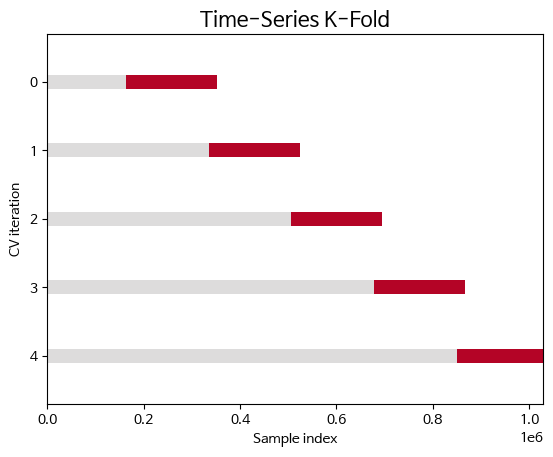

In [ ]:
# TimeSeriesSplit를 시각화합니다.
fig, ax = plt.subplots()
plot_cv_indices(x=X_train,
                y=y_train,
                cv=kf,
                ax=ax,
                split_strategy='Time-Series K-Fold')

In [ ]:
# 학습 데이터를 TimeSeriesSplit로 나눕니다.
train_folds = list(kf.split(X_train, y_train))
display(train_folds)

[(array([     0,      1,      2, ..., 171596, 171597, 171598]),
  array([171599, 171600, 171601, ..., 343191, 343192, 343193])),
 (array([     0,      1,      2, ..., 343191, 343192, 343193]),
  array([343194, 343195, 343196, ..., 514786, 514787, 514788])),
 (array([     0,      1,      2, ..., 514786, 514787, 514788]),
  array([514789, 514790, 514791, ..., 686381, 686382, 686383])),
 (array([     0,      1,      2, ..., 686381, 686382, 686383]),
  array([686384, 686385, 686386, ..., 857976, 857977, 857978])),
 (array([     0,      1,      2, ..., 857976, 857977, 857978]),
  array([ 857979,  857980,  857981, ..., 1029571, 1029572, 1029573]))]

#### 5-2-2. LightGBM

Baseline 기준으로 모델평가

* RandomForest: 5850.79
* XGBoost: 4403.02
* LightGBM: 4114.19 ⭐
* CatBoost: 4607.88


> 성과가 가장 좋은 LightGBM으로 학습을 진행합니다.

In [ ]:
%%time
fold_save_files = []

for fold_idx, (train_idx, valid_idx) in enumerate(train_folds):
    display(f"--------{fold_idx}번째 fold의 학습을 시작합니다.--------")

    # index를 통해 fold의 학습세트를 가져옵니다.
    X_train_fold = X_train.iloc[train_idx, :]
    y_train_fold = y_train[train_idx]

    # index를 통해 fold의 평가세트를 가져옵니다.
    X_valid_fold = X_train.iloc[valid_idx, :]
    y_valid_fold = y_train[valid_idx]

    # fold의 데이터로 학습을 진행합니다.
    gbm = lgb.LGBMRegressor(n_estimators=100000,
                            metric="rmse",)
    gbm.fit(X_train_fold, y_train_fold,                                               # 학습 데이터
        eval_set=[(X_train_fold, y_train_fold), (X_valid_fold, y_valid_fold)],          # 검증데이터
        eval_metric ='rmse',                                                            # 평가지표
        categorical_feature="auto",
        callbacks=[lgb.early_stopping(stopping_rounds=50),                              # 10번의 성능향상이 없을 경우, 학습을 멈춥니다.
                   lgb.log_evaluation(period=10, show_stdv=True)]                       # 매 iteration마다 학습결과를 출력합니다.
    )

    # 각 fold별 학습한 모델을 저장합니다.
    file_name = f"timeseries_fold{fold_idx}_gbm.pkl"
    joblib.dump(gbm, file_name)
    display(f"--------{fold_idx}번째 fold는 {file_name}에 저장되었습니다.--------\n\n")
    fold_save_files.append(file_name)


'--------0번째 fold의 학습을 시작합니다.--------'

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1582
[LightGBM] [Info] Number of data points in the train set: 171599, number of used features: 9
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 37363.563838
Training until validation scores don't improve for 50 rounds
[10]	training's rmse: 13349.6	valid_1's rmse: 13831.8
[20]	training's rmse: 10528.4	valid_1's rmse: 11208.2
[30]	training's rmse: 9282.14	valid_1's rmse: 10426.2
[40]	training's rmse: 8584.54	valid_1's rmse: 9969
[50]	training's rmse: 8088.92	valid_1's rmse: 9660.81
[60]	training's rmse: 7726.1	valid_1's rmse: 9511.7
[70]	training's rmse: 7451.59	valid_1's rmse: 9376

'--------0번째 fold는 timeseries_fold0_gbm.pkl에 저장되었습니다.--------\n\n'

'--------1번째 fold의 학습을 시작합니다.--------'

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1633
[LightGBM] [Info] Number of data points in the train set: 343194, number of used features: 9
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 39507.214578
Training until validation scores don't improve for 50 rounds
[10]	training's rmse: 13538.4	valid_1's rmse: 12692.7
[20]	training's rmse: 10658.3	valid_1's rmse: 10064.9
[30]	training's rmse: 9445.78	valid_1's rmse: 9093.75
[40]	training's rmse: 8629.33	valid_1's rmse: 8447.38
[50]	training's rmse: 8175.09	valid_1's rmse: 8202.76
[60]	training's rmse: 7788.83	valid_1's rmse: 7946
[70]	training's rmse: 7539.45	valid_1's rmse: 77

'--------1번째 fold는 timeseries_fold1_gbm.pkl에 저장되었습니다.--------\n\n'

'--------2번째 fold의 학습을 시작합니다.--------'

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1664
[LightGBM] [Info] Number of data points in the train set: 514789, number of used features: 9
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 40343.271088
Training until validation scores don't improve for 50 rounds
[10]	training's rmse: 13256.2	valid_1's rmse: 18040.5
[20]	training's rmse: 10359.9	valid_1's rmse: 14919.7
[30]	training's rmse: 9053.92	valid_1's rmse: 13422.2
[40]	training's rmse: 8355.1	valid_1's rmse: 12501.3
[50]	training's rmse: 7901.11	valid_1's rmse: 11853.6
[60]	training's rmse: 7574.9	valid_1's rmse: 11460.4
[70]	training's rmse: 7306.07	valid_1's rmse: 1

'--------2번째 fold는 timeseries_fold2_gbm.pkl에 저장되었습니다.--------\n\n'

'--------3번째 fold의 학습을 시작합니다.--------'

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1690
[LightGBM] [Info] Number of data points in the train set: 686384, number of used features: 9
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 42484.449578
Training until validation scores don't improve for 50 rounds
[10]	training's rmse: 14169.4	valid_1's rmse: 33833.9
[20]	training's rmse: 11208.5	valid_1's rmse: 29036.2
[30]	training's rmse: 9739.27	valid_1's rmse: 26258.6
[40]	training's rmse: 8887.56	valid_1's rmse: 24362.9
[50]	training's rmse: 8355.37	valid_1's rmse: 23256.1
[60]	training's rmse: 7982.08	valid_1's rmse: 22589.4
[70]	training's rmse: 7659.15	valid_1's rmse:

'--------3번째 fold는 timeseries_fold3_gbm.pkl에 저장되었습니다.--------\n\n'

'--------4번째 fold의 학습을 시작합니다.--------'

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1722
[LightGBM] [Info] Number of data points in the train set: 857979, number of used features: 9
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 46556.617866
Training until validation scores don't improve for 50 rounds
[10]	training's rmse: 17473.7	valid_1's rmse: 48479
[20]	training's rmse: 13510.9	valid_1's rmse: 40460.8
[30]	training's rmse: 11707.6	valid_1's rmse: 36199.8
[40]	training's rmse: 10540.4	valid_1's rmse: 33636.1
[50]	training's rmse: 9805.91	valid_1's rmse: 32159.5
[60]	training's rmse: 9328.91	valid_1's rmse: 31134.3
[70]	training's rmse: 8958.9	valid_1's rmse: 30

'--------4번째 fold는 timeseries_fold4_gbm.pkl에 저장되었습니다.--------\n\n'

CPU times: user 8min 51s, sys: 775 ms, total: 8min 52s
Wall time: 54.1 s


In [ ]:
# model = lgb.LGBMRegressor(n_estimators=100000,
#                           metric="rmse",)
# model.fit(X_train2, y_train,
#         eval_set=[(X_train2, y_train), (X_val2, y_val)],
#         eval_metric = 'rmse',
#         categorical_feature="auto",
#         callbacks=[lgb.early_stopping(stopping_rounds=50),
#                    lgb.log_evaluation(period=10, show_stdv=True)]
#         )

In [ ]:
# import lightgbm as lgb

# model = lgb.LGBMRegressor(n_estimators=100000,                # early stopping을 적용
#                           metric="rmse",
#                           data_sample_strategy='goss',        # sampling 방법을 goss로 적용
#                           max_depth=20,                       # default값인 20에서 12로 변경
#                           num_leaves=31,                      # default값인 31에서 62으로 변경
#                           min_data_in_leaf=20                 # default값인 20에서 40으로 변경
#                           )
# model.fit(X_train2, y_train,
#         eval_set=[(X_train2, y_train), (X_val2, y_val)],
#         eval_metric = 'rmse',
#         categorical_feature="auto",
#         callbacks=[lgb.early_stopping(stopping_rounds=50),
#                    lgb.log_evaluation(period=10, show_stdv=True)]
#         )

In [ ]:
print(f"X_train 컬럼 수: {X_train.shape[1]}")
print(f"X_test 컬럼 수: {X_test.shape[1]}")


X_train 컬럼 수: 9
X_test 컬럼 수: 9


In [ ]:
# print("X_train 컬럼 이름:", X_train.columns)
# print("X_test 컬럼 이름:", X_test.columns)


In [ ]:
# # 훈련 데이터와 테스트 데이터의 컬럼을 동일하게 맞추기
# X_test = X_test[X_train.columns]


In [ ]:
# 저장한 학습모델들을 불러와, Testset에 대한 추론을 진행합니다.
# 각 fold의 예측결과를 평균을 취하는 방식으로 진행합니다.
total_predicts = np.zeros(len(X_test))

for file_name in fold_save_files:
    gbm_trained = joblib.load(file_name)
    fold_predicts = gbm_trained.predict(X_test)

    # 각 fold의 rmse를 측정합니다.
    RMSE = mean_squared_error(y_test, fold_predicts)**0.5
    display(f"{file_name} - Test rmse : {RMSE}")

    total_predicts += fold_predicts / len(fold_save_files)

RMSE = mean_squared_error(y_test, total_predicts)**0.5
display(f"최종 Test rmse : {RMSE}")

'timeseries_fold0_gbm.pkl - Test rmse : 53830.15840278824'

'timeseries_fold1_gbm.pkl - Test rmse : 47587.42470816524'

'timeseries_fold2_gbm.pkl - Test rmse : 53061.5684018354'

'timeseries_fold3_gbm.pkl - Test rmse : 64167.81084079026'

'timeseries_fold4_gbm.pkl - Test rmse : 95153.60257290278'

'최종 Test rmse : 62404.92211246316'

In [ ]:
# 위 학습 로그에서 검증세트를 기준으로 rmse가 가장 낮은 3개의 모델을 선택후 추론을 진행합니다.
top_3_files = ["timeseries_fold0_gbm.pkl", "timeseries_fold1_gbm.pkl", "timeseries_fold2_gbm.pkl"]
total_predicts = np.zeros(len(X_test))

for file_name in top_3_files:
    gbm_trained = joblib.load(file_name)
    fold_predicts = gbm_trained.predict(X_test)

    # 각 fold의 rmse를 측정합니다.
    RMSE = mean_squared_error(y_test, fold_predicts)**0.5
    display(f"{file_name} - Test rmse : {RMSE}")

    total_predicts += fold_predicts / len(top_3_files)

RMSE = mean_squared_error(y_test, total_predicts)**0.5
display(f"최종 Test rmse : {RMSE}")

'timeseries_fold0_gbm.pkl - Test rmse : 53830.15840278824'

'timeseries_fold1_gbm.pkl - Test rmse : 47587.42470816524'

'timeseries_fold2_gbm.pkl - Test rmse : 53061.5684018354'

'최종 Test rmse : 51329.50203306695'

> - [Base Line]시간순으로 정렬된 Time-Series Split 학습의 최종결과는 아래와 같습니다.

  - Training Time :  s
  - Train RMSE : fold마다 다름
  - Valid RMSE : fold마다 다름
  - Test RMSE(ALL) : 63125.44
  - Test RMSE(Top3) : 52347.08
  - Test RMSE(Top1) : 48200.19

> Feature Importance

  - Training Time :  s
  - Train RMSE : fold마다 다름
  - Valid RMSE : fold마다 다름
  - Test RMSE(ALL) : 62404.92
  - Test RMSE(Top3) : 51329.50
  - Test RMSE(Top1) : 47587.42

In [ ]:
# 저장된 모델 파일 목록
fold_save_files = [
    "timeseries_fold0_gbm.pkl",
    "timeseries_fold1_gbm.pkl",
    "timeseries_fold2_gbm.pkl",
    "timeseries_fold3_gbm.pkl",
    "timeseries_fold4_gbm.pkl"
]


# 예측값을 저장할 리스트 초기화
predictions = []

# 각 저장된 모델을 불러와서 예측
for file_name in fold_save_files:
    # 모델 불러오기
    gbm = joblib.load(file_name)

    # 예측
    preds = gbm.predict(X_test)
    predictions.append(preds)

# 예측값을 numpy 배열로 변환
predictions = np.array(predictions)

# 예측값의 평균을 구하여 최종 예측값 산출
final_predictions = np.mean(predictions, axis=0)

# 제출 파일 작성
submission = pd.DataFrame({
    # 'id': X_test['id'],  # 'id' 열이 있는 경우
    'target': final_predictions  # 예측값
})

# 제출 파일 저장
submission.to_csv('submission.csv', index=False)



In [ ]:
# 테스트 RMSE 계산
rmse_final = np.sqrt(mean_squared_error(y_test, final_predictions))
print(rmse_final)

51329.50203306695


- fold0~4 평균: 63125.44
- fold0~2 평균: 52347.08

In [ ]:
## 예측값 저장하기

In [ ]:
# # 저장된 모델을 불러옵니다.
# with open('saved_model.pkl', 'rb') as f:
#     model = pickle.load(f)

In [ ]:

...
%%time
# X_test = X_test.drop(['target'], axis=1)

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = gbm.predict(X_test)

real_test_pred          # 예측값들이 출력됨을 확인할 수 있습니다.

# 실제 값 준비 (예시로 dt_test에 'target' 열이 실제 값을 포함한다고 가정합니다)
y_test = dt_test['target']

# RMSE 계산
rmse = np.sqrt(mean_squared_error(y_test, real_test_pred))

# 결과 출력
print(f"Test RMSE: {rmse}")

# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)


UsageError: Line magic function `%%time` not found.


## 6.시각화

##### 5.1. ✔ Metric visualize
- 매번의 반복에서 학습데이터와 검증데이터에 대한 Metric을 시각화합니다.
- 평가지표에 대한 정량적인 수치를 나열하는 것보다 학습의 추세, 패턴 및 변동을 더욱 한눈에 이해할 수 있습니다.
  - 프로젝트 진행 시, 서로간의 의사소통에서 더욱 효과적으로 사용할 수 있습니다.


In [ ]:
# # 학습된 gbm의 parameter들을 불러옵니다.

# gbm_params = gbm_trained.get_params()
# print(json.dumps(gbm_params, indent=4)) # 보기 편하게 나타내기 위해, json 형태로 변환합니다.

In [ ]:
# # 학습결과를 시각화합니다.

# fig = plt.figure(figsize=(8, 8))
# plt.subplot(1, 1, 1)
# plt.plot(np.arange(len(list(gbm_trained.evals_result_['training']['rmse']))), list(gbm_trained.evals_result_['training']['rmse']), 'b-',
#          label='Train Set')
# plt.plot(np.arange(len(list(gbm_trained.evals_result_['training']['rmse']))), list(gbm_trained.evals_result_['valid_1']['rmse']), 'r-',
#          label='Valid Set')
# plt.legend(loc='upper right')
# plt.xlabel('Boosting Iterations')
# plt.ylabel('Rmse')
# fig.tight_layout()
# plt.show()

##### 5.2. ✔ Predict visualize
- 실제 예측결과를 다양한 관점에서 시각화합니다.
- 모델의 예측결과를 수치적인 지표를 통해서 하나하나 비교하기에는 한계가 있습니다.
  - 모델의 예측결과를 시각화하면서 문제점을 찾고 개선의 방향을 탐색할 수 있습니다.


> 지역별 등으로 구분해서 RMSE 파악해 보기

In [ ]:
# # 종목별로 valid set에 대한 rmse를 측정합니다.

# code_li = list(X_valid['LEncodedCode'].unique())  # 종목리스트를 만듭니다.

# valid_rmse_li = []                                # 종목별 rmse를 저장할 리스트를 선언합니다.
# for code in code_li:                              # 종목별로 rmse측정을 진행합니다.
#   valid_sets = X_valid.loc[X_valid['LEncodedCode']==code] # 해당 종목의 input을 가져옵니다.

#   valid_predicts = gbm_trained.predict(valid_sets, verbosity=-1) # 추론을 진행합니다.

#   valid_rmse_li.append(mean_squared_error(Y_valid[valid_sets.index], valid_predicts)**0.5) # 추론결과로 rmse를 계산하고 저장합니다.

- 변수 중요도도 확인해보도록 하겠습니다.

In [ ]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(gbm.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [ ]:
# 상관관계 행렬 계산
corr_matrix = X_train.corr()

# 상관관계 절대값이 0.95 이상 1 이하인 것 추출
filtered_corr = corr_matrix.unstack().reset_index()
filtered_corr.columns = ['Feature1', 'Feature2', 'Correlation']
filtered_corr['AbsCorrelation'] = filtered_corr['Correlation'].abs()

# 동일한 피처 조합이 두 번 나타나지 않도록 하위 삼각 행렬만 사용
filtered_corr = filtered_corr[filtered_corr['Feature1'] < filtered_corr['Feature2']]

# 조건에 맞는 상관관계 필터링
filtered_corr = filtered_corr[(filtered_corr['AbsCorrelation'] >= 0.95) & (filtered_corr['AbsCorrelation'] < 1)]

# 상관관계를 절대값 기준으로 높은 순으로 정렬
filtered_corr = filtered_corr.sort_values(by='AbsCorrelation', ascending=False)

# 결과 출력
print("\n상관관계 값이 0.95 이상 1 미만인 것:")
print(filtered_corr)


In [ ]:
# 상관관계 히트맵 시각화
plt.figure(figsize=(12, 10))  # 그래프 크기 설정
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5, linecolor='black')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('saved_model.pkl', 'wb') as f:
    pickle.dump(gbm, f)

### 5.3. Feature selection

- 분석 결과 "계약년", "전용면적" 변수가 유의한 변수로 보입니다. 따라서 이 변수로 또 다른 파생변수를 더 생성해보거나, 중요도가 낮아보이는 변수를 제거해 차원의 저주를 막아볼 수도 있습니다.

### 5.4. Valid prediction 분석

- 예측값을 분석해보기 위해 valid prediction을 확인해보겠습니다.

In [ ]:
# Validation dataset에 target과 pred 값을 채워주도록 하겠습니다.
X_val['target'] = y_val
X_val['pred'] = pred

In [ ]:
# Squared_error를 계산하는 함수를 정의하겠습니다.
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

# RMSE 계산
squared_errors = calculate_se(X_val['target'], X_val['pred'])
X_val['error'] = squared_errors

In [ ]:
# Error가 큰 순서대로 sorting 해 보겠습니다.
X_val_sort = X_val.sort_values(by='error', ascending=False)       # 내림차순 sorting

In [ ]:
X_val_sort.head()

- 예측을 잘 하지 못한 top 100개의 데이터와 예측을 잘한 top 100개의 데이터를 비교해보겠습니다.

In [ ]:
X_val_sort_top100 = X_val.sort_values(by='error', ascending=False).head(100)        # 예측을 잘 하지못한 top 100개의 data
X_val_sort_tail100 = X_val.sort_values(by='error', ascending=False).tail(100)       # 예측을 잘한 top 100개의 data

In [ ]:
# 해석을 위해 레이블인코딩 된 변수를 복원해줍니다.
error_top100 = X_val_sort_top100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    error_top100[column] = label_encoders[column].inverse_transform(X_val_sort_top100[column])

best_top100 = X_val_sort_tail100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    best_top100[column] = label_encoders[column].inverse_transform(X_val_sort_tail100[column])

In [ ]:
display(error_top100.head(1))
display(best_top100.head(1))

- 이제 분포를 비교해보도록 하겠습니다.

In [ ]:
sns.boxplot(data = error_top100, x='target')
plt.title('The worst top100 prediction의 target 분포')
plt.show()

sns.boxplot(data = best_top100, x='target', color='orange')
plt.title('The best top100 prediction의 target 분포')
plt.show()

- Taget 분포를 보니 좋은 예측을 보인 top 100개의 data보다 상대적으로 나쁜 예측을 보인 top 100 dataset들이 높은 가격을 보였음을 확인할 수 있습니다. 이에 대한 모델링 및 처리가 필요해보입니다.

In [ ]:
sns.histplot(data = error_top100, x='전용면적', alpha=0.5)
sns.histplot(data = best_top100, x='전용면적', color='orange', alpha=0.5)
plt.title('전용면적 분포 비교')
plt.show()

- 전용면적 또한 나쁜 예측을 보인 집들이 더 넓음을 확인할 수 있습니다.

## 7.Inference

In [ ]:
dt_test.head(2)      # test dataset에 대한 inference를 진행해보겠습니다.

In [ ]:
# 저장된 모델을 불러옵니다.
with open('saved_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [ ]:
%%time
# X_test = X_test.drop(['target'], axis=1)

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = gbm.predict(X_test)

In [ ]:
real_test_pred          # 예측값들이 출력됨을 확인할 수 있습니다.

## 8.Output File Save

In [ ]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)

In [ ]:
# 저장된 모델을 불러옵니다.
with open('saved_model.pkl', 'rb') as f:
    model = pickle.load(f)

%%time
# X_test = X_test.drop(['target'], axis=1)

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = gbm.predict(X_test)

real_test_pred          # 예측값들이 출력됨을 확인할 수 있습니다.

# 실제 값 준비 (예시로 dt_test에 'target' 열이 실제 값을 포함한다고 가정합니다)
y_test = dt_test['target']

# RMSE 계산
rmse = np.sqrt(mean_squared_error(y_test, real_test_pred))

# 결과 출력
print(f"Test RMSE: {rmse}")

# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)

